# Siamese One-Shot-Learning Network, MNIST

In [1]:
import os
import codecs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import datetime
import time

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image

## Set Configs

In [3]:
DO_LEARN = True
SAVE_FREQUENCY = 2
BATCH_SIZE = 16
LR = 0.001
N_EPOCHS = 10
WEIGHT_DECAY = 0.0001

In [4]:
LOAD_MODEL_PATH = './weights/'

## Set Helpers

In [5]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [6]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
    assert get_int(data[:4]) == 2051
    length = get_int(data[4:8])
    num_rows = get_int(data[8:12])
    num_cols = get_int(data[12:16])
    
    images = []
    parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
    
    return torch.from_numpy(parsed).view(length, num_rows, num_cols)

In [7]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
    assert get_int(data[:4]) == 2049
    length = get_int(data[4:8])
    parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
    
    return torch.from_numpy(parsed).view(length).long()

## Configure Custom Data Loader

In [8]:
class SiameseNetworkDataset(torch.utils.data.Dataset):
    """ Dataset that on each iteration will provides two pairs of MNIST images randomly. 
        One pair is of the same number (positive sample) and 
        other one is of the two different numbers (negative sample).
    """
    
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'
    
    def __init__(self, root, train=True, transform=None, label_transform=None, download=False):
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.label_transform = label_transform
        self.train = train
        
        if download:
            self.download()
            
        if not self._check_exists():
            raise RuntimeError('Dataset not found.' + ' You can use download=True to download it.')
            
        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))
            
            train_data_class = []
            train_labels_class = []
            for i in range(10):
                indices = torch.squeeze((self.train_labels == i).nonzero())
                train_data_class.append(torch.index_select(self.train_data, 0, indices))
                train_labels_class.append(torch.index_select(self.train_labels, 0, indices))

            # generated balanced pairs
            self.train_data = []
            self.train_labels = []
            lengths = [x.shape[0] for x in train_labels_class]
            for i in range(10):
                for j in range(500):
                    random_class  = random.randint(0,8)
                    if random_class >= i:
                        random_class = random_class + 1
                        
                    random_dist = random.randint(0,100)
                    
                    self.train_data.append(torch.stack([train_data_class[i][j], train_data_class[i][j+random_dist], train_data_class[random_class][j]]))
                    self.train_labels.append([1,0])
                    
            self.train_data = torch.stack(self.train_data)
            self.train_labels = torch.tensor(self.train_labels)
            
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))
            
            test_data_class = []
            test_labels_class = []
            for i in range(10):
                indices = torch.squeeze((self.test_labels == i).nonzero())
                test_data_class.append(torch.index_select(self.test_data, 0, indices))
                test_labels_class.append(torch.index_select(self.test_labels, 0, indices))
                
            # generated balanced pairs
            self.test_data = []
            self.test_labels = []
            lengths = [x.shape[0] for x in test_labels_class]
            for i in range(10):
                for j in range(500):
                    random_class  = random.randint(0,8)
                    if random_class >= i:
                        random_class = random_class + 1
                        
                    random_dist = random.randint(0,100)
                    
                    self.test_data.append(torch.stack([test_data_class[i][j], test_data_class[i][j+random_dist], test_data_class[random_class][j]]))
                    self.test_labels.append([1,0])
                    
            self.test_data = torch.stack(self.test_data)
            self.test_labels = torch.tensor(self.test_labels)
            
    def __getitem__(self, index):
        if self.train:
            images, labels = self.train_data[index], self.train_labels[index]
        else:
            images, labels = self.test_data[index], self.test_labels[index]
            
        image_list = []
        for i in range(len(images)):
            image = Image.fromarray(images[i].numpy(), mode='L')
            if self.transform is not None:
                image = self.transform(image)
            image_list.append(image)
            
        if self.label_transform is not None:
            labels = self.label_transform(labels)
            
        return image_list, labels
    
    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)
        
    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
         os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))
    
    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.label_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        
        return fmt_str
        
    def download(self):
        """ Download the MNIST data if it doesn't exist in processed_folder already. """
        from six.moves import urllib
        import gzip
        
        if self._check_exists():
            return
        
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise
        
        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                   gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)
            
        print('Processing...')
        
        training_set = (
            read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        
        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

## Build [Siamese Network](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Architecture

In [9]:
class SiameseNet(nn.Module):
    
    def __init__(self):
        super(SiameseNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 7)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.linear1 = nn.Linear(2304, 512)
        self.linear2 = nn.Linear(512, 2)
        
    def forward(self, data):
        fvectors = []
        for i in range(2): # the layers in the two subnetworks share the same weights
            x = data[i]
            x = self.conv1(x)
            x = F.relu(x)
            x = self.pool1(x)
            
            x = self.conv2(x)
            x = F.relu(x)
            x = self.conv3(x)
            x = F.relu(x)
            
            x = x.view(x.shape[0], -1)
            x = self.linear1(x)
            fvectors.append(F.relu(x))
            
        # calculate absolute difference between the two feature vectors
        distance = torch.abs(fvectors[1] - fvectors[0])
        score = self.linear2(distance)
        
        return score

In [10]:
train_loss_history = []
def train(model, device, train_loader, epoch, optimizer):
    model.train()
    
    print('# -----------------')
    print('# TRAINING PROCESS')
    print('# -----------------')
    for batch_idx, (image, label) in enumerate(train_loader):
        for i in range(len(image)):
            image[i] = image[i].to(device)
            
        optimizer.zero_grad()
        result_positive = model(image[:2])
        result_negative = model(image[0:3:2])
        
        label = label.type(torch.LongTensor).to(device)
        label_positive = torch.squeeze(label[:,0])
        label_negative = torch.squeeze(label[:,1])
        
        # calculating loss using cross entropy
        loss_positive = F.cross_entropy(result_positive, label_positive)
        loss_negative = F.cross_entropy(result_negative, label_negative)
        
        loss = loss_positive + loss_negative
        loss.backward()
        
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(epoch+1,
                                                                          batch_idx*BATCH_SIZE,
                                                                          len(train_loader.dataset),
                                                                          100. * batch_idx*BATCH_SIZE / len(train_loader.dataset),
                                                                          loss.item()))
        train_loss_history.append(loss.item())

In [11]:
accuracy_history = []
test_loss_history = []
def test(model, device, test_loader):
    model.eval()
    
    print('# -----------------')
    print('# TESTING PROCESS')
    print('# -----------------')
    with torch.no_grad():
        
        accurate_labels = 0
        all_labels = 0
        loss = 0
        for batch_idx, (image, label) in enumerate(test_loader):
            for i in range(len(image)):
                image[i] = image[i].to(device)
                
            result_positive = model(image[:2])
            result_negative = model(image[0:3:2])
            
            label = label.type(torch.LongTensor).to(device)
            label_positive = torch.squeeze(label[:,0])
            label_negative = torch.squeeze(label[:,1])
            
            # define CROSS-ENTROPY loss function
            loss_positive = F.cross_entropy(result_positive, label_positive)
            loss_negative = F.cross_entropy(result_negative, label_negative)
            
            loss = loss + loss_positive + loss_negative
            
            accurate_labels_positive = torch.sum(torch.argmax(result_positive, dim=1) == label_positive).cpu()
            accurate_labels_negative = torch.sum(torch.argmax(result_negative, dim=1) == label_negative).cpu()
            
            accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
            all_labels = all_labels + len(label_positive) + len(label_negative)
            
        accuracy = 100. * accurate_labels / all_labels
        print('Test Accuracy: {}/{} ({:.3f}%) Loss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))
        accuracy_history.append(accuracy)
        test_loss_history.append(loss)

In [12]:
def one_shot(model, device, data):
    model.eval()
    
    with torch.no_grad():
        for i in range(len(data)):
            data[i] = data[i].to(device)
            
        output = model(data)
        return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

In [13]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5,), (1.0,))])
    
    siamese = SiameseNet().to(device)
    
    if DO_LEARN:
        train_loader = torch.utils.data.DataLoader(SiameseNetworkDataset('./datasets', train=True, download=True, transform=transform), 
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True)
        test_loader = torch.utils.data.DataLoader(SiameseNetworkDataset('./datasets', train=False, download=True, transform=transform),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False)
        
        optimizer = optim.Adam(siamese.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        for epoch in range(N_EPOCHS):
            train(siamese, device, train_loader, epoch, optimizer)
            test(siamese, device, test_loader)
            if epoch & SAVE_FREQUENCY == 0:
                if not os.path.exists('./weights/mnist/'): os.makedirs('./weights/mnist/')
                torch.save(siamese, './weights/mnist/siamese_{:03}.pt'.format(epoch))
                
    else:
        prediction_loader = torch.utils.data.DataLoader(SiameseNetworkDataset('./datasets', train=False, download=True, transform=transform),
                                                        batch_size=1,
                                                        shuffle=True)
        siamese.load_state_dict(torch.load(LOAD_MODEL_PATH))
        
        data = []
        data.extend(next(iter(prediction_loader))[0][:3:2])
        
        similarity_score = one_shot(siamese, device, data)
        if similarity_score > 0:
            print('These two images are of the same number.')
        else:
            print('These two images are not of the same number.')

In [14]:
if __name__ == '__main__':
    main()

# -----------------
# TRAINING PROCESS
# -----------------
Train Epoch: 1 [0/5000 (0%)] Loss: 1.386668
Train Epoch: 1 [160/5000 (3%)] Loss: 1.405831
Train Epoch: 1 [320/5000 (6%)] Loss: 1.104902
Train Epoch: 1 [480/5000 (10%)] Loss: 1.304910
Train Epoch: 1 [640/5000 (13%)] Loss: 1.076337
Train Epoch: 1 [800/5000 (16%)] Loss: 1.365111
Train Epoch: 1 [960/5000 (19%)] Loss: 1.121461
Train Epoch: 1 [1120/5000 (22%)] Loss: 1.073384
Train Epoch: 1 [1280/5000 (26%)] Loss: 1.181340
Train Epoch: 1 [1440/5000 (29%)] Loss: 0.973360
Train Epoch: 1 [1600/5000 (32%)] Loss: 1.018147
Train Epoch: 1 [1760/5000 (35%)] Loss: 0.622911
Train Epoch: 1 [1920/5000 (38%)] Loss: 0.882555
Train Epoch: 1 [2080/5000 (42%)] Loss: 1.001866
Train Epoch: 1 [2240/5000 (45%)] Loss: 0.898820
Train Epoch: 1 [2400/5000 (48%)] Loss: 0.767621
Train Epoch: 1 [2560/5000 (51%)] Loss: 0.737490
Train Epoch: 1 [2720/5000 (54%)] Loss: 1.025461
Train Epoch: 1 [2880/5000 (58%)] Loss: 0.789482
Train Epoch: 1 [3040/5000 (61%)] Loss: 0.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [160/5000 (3%)] Loss: 0.671898
Train Epoch: 2 [320/5000 (6%)] Loss: 0.444284
Train Epoch: 2 [480/5000 (10%)] Loss: 0.432332
Train Epoch: 2 [640/5000 (13%)] Loss: 0.223481
Train Epoch: 2 [800/5000 (16%)] Loss: 0.206708
Train Epoch: 2 [960/5000 (19%)] Loss: 0.760343
Train Epoch: 2 [1120/5000 (22%)] Loss: 0.616049
Train Epoch: 2 [1280/5000 (26%)] Loss: 0.478408
Train Epoch: 2 [1440/5000 (29%)] Loss: 0.500702
Train Epoch: 2 [1600/5000 (32%)] Loss: 0.473064
Train Epoch: 2 [1760/5000 (35%)] Loss: 0.308579
Train Epoch: 2 [1920/5000 (38%)] Loss: 0.201095
Train Epoch: 2 [2080/5000 (42%)] Loss: 0.374639
Train Epoch: 2 [2240/5000 (45%)] Loss: 0.251820
Train Epoch: 2 [2400/5000 (48%)] Loss: 0.222503
Train Epoch: 2 [2560/5000 (51%)] Loss: 0.655504
Train Epoch: 2 [2720/5000 (54%)] Loss: 0.632482
Train Epoch: 2 [2880/5000 (58%)] Loss: 0.325963
Train Epoch: 2 [3040/5000 (61%)] Loss: 0.133315
Train Epoch: 2 [3200/5000 (64%)] Loss: 0.149623
Train Epoch: 2 [3360/5000 (67%)] Loss: 0.310153


Train Epoch: 6 [4960/5000 (99%)] Loss: 0.130851
# -----------------
# TESTING PROCESS
# -----------------
Test Accuracy: 9550/10000 (95.000%) Loss: 97.475861
# -----------------
# TRAINING PROCESS
# -----------------
Train Epoch: 7 [0/5000 (0%)] Loss: 0.005343
Train Epoch: 7 [160/5000 (3%)] Loss: 0.024588
Train Epoch: 7 [320/5000 (6%)] Loss: 0.007436
Train Epoch: 7 [480/5000 (10%)] Loss: 0.003950
Train Epoch: 7 [640/5000 (13%)] Loss: 0.074852
Train Epoch: 7 [800/5000 (16%)] Loss: 0.006160
Train Epoch: 7 [960/5000 (19%)] Loss: 0.060767
Train Epoch: 7 [1120/5000 (22%)] Loss: 0.004025
Train Epoch: 7 [1280/5000 (26%)] Loss: 0.003050
Train Epoch: 7 [1440/5000 (29%)] Loss: 0.002720
Train Epoch: 7 [1600/5000 (32%)] Loss: 0.017318
Train Epoch: 7 [1760/5000 (35%)] Loss: 0.611462
Train Epoch: 7 [1920/5000 (38%)] Loss: 0.022613
Train Epoch: 7 [2080/5000 (42%)] Loss: 0.179711
Train Epoch: 7 [2240/5000 (45%)] Loss: 0.114453
Train Epoch: 7 [2400/5000 (48%)] Loss: 0.124614
Train Epoch: 7 [2560/5000 (

## Evaluate The Network

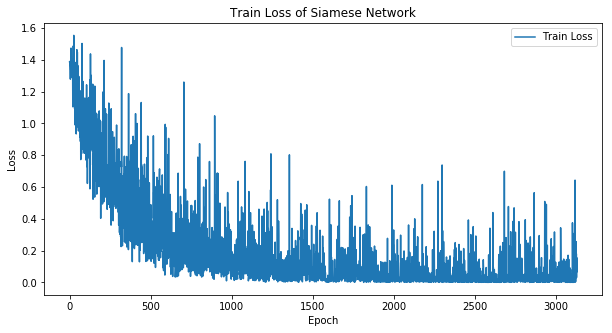

In [15]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Siamese Network")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/mnist/'): os.makedirs('./images/mnist/')
plt.savefig('./images/mnist/final_train_loss.png')
plt.show()

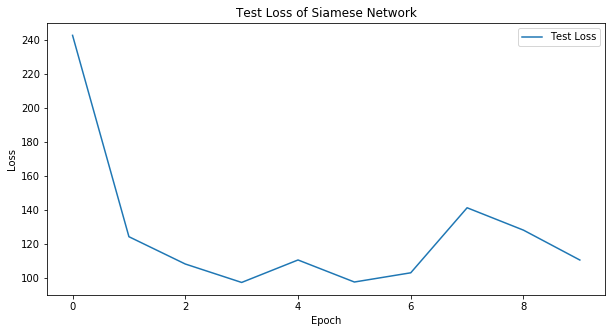

In [16]:
plt.figure(figsize=(10,5))
plt.title("Test Loss of Siamese Network")
plt.plot(test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/mnist/'): os.makedirs('./images/mnist/')
plt.savefig('./images/mnist/final_test_loss.png')
plt.show()

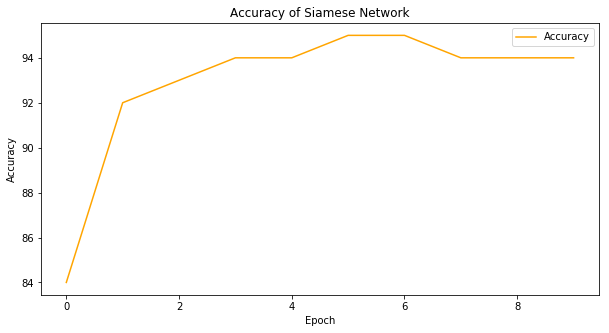

In [17]:
plt.figure(figsize=(10,5))
plt.title("Accuracy of Siamese Network")
plt.plot(accuracy_history, color='orange', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

if not os.path.exists('./images/mnist/'): os.makedirs('./images/mnist/')
plt.savefig('./images/mnist/final_accuracy.png')
plt.show()

---